## Relationships between words
### n-grams and correlations
Read: http://tidytextmining.com/ngrams.html

Exploring relationships and connections between words.
1. Tokenizing by n-gram, here by bigrams for a start
2. Counting and filtering n-grams: Most common bigrams, then remove the ones where at least one is a stop word.
3. Analyzing bigrams: one bigram per row: look at the tf-idf (the one with the highest), can be visualized for each document(/book in example).
4. Using them to provide context in sentiment analysis: The approach is to count certain word segments like "happy" and "not happy". We examine how often sentiment-associated words are preceded by "not" or other negating words. We use the `AFINN lexicon for sentiment analysis`. Is there something similar in german for sentiment analysis? -> http://www.ulliwaltinger.de/sentiment/ (gives negative, positive and neutral words in tsv-format, not sure if the words have a "sentiment score")
5. Calculate sentiment score per comment
6. Visualize a network of bigrams: node1 = word1 -> node2 = word2 of bigram, weight given by the number of occurence of the bigram. For each word we only show the words that follows it the most as connected directed node. Only show bigrams that occured at least x times.  
An useful and flexibel way to visualize relational data. - This is a visualization of a Markov chain.
7. Put the whole thing built so far into a function for usage on other texts
8. We may be interested in words that tend to co-occur within particular documents or particular chapters, even if they don't occur next to each other. Turn text into a wide matrix first for that.  
Counting and correlating among sections: Package like `widyr` in R for that? (`pairwise_count`)
9. Most common co-occuring words not that meaningful since they're also the most common individual words. We may instead want to examine correlation among words, which indicates how often they appear together relative to how often they appear separately (phi coefficient ~ pearson correlation for binary data).  
Pick some interesting words and look at their correlations. Then plot a graph for highest correlations like above.
    
Pairs of consecutive words might capture structure that isn't present when one is just counting single words, and may provide context that makes tokens more understandable (for example "pulteney street" instead of "pulteney" only). However, the per-bigram counts are also sparser since they are rarer.

In [3]:
# Initialize libraries and data
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from time import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv').sample(30000) # crop because battery life, skews data
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

## Sentiment analysis
The idea is to build each a Vectorizer with for all negative and for all positive words. In a next step we will go trough each comment(/row) and check how often each words appears in its text. Then we sum up those appearances and so get a score of 

$$ \text{# pos} - \text{# neg} = \text{"sentiment score"}$$

In [4]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, "
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei, "
stop_words += "nichts"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Datasets from http://www.ulliwaltinger.de/sentiment/
from sklearn.feature_extraction.text import CountVectorizer

# TODO remove bigrams from the datasets?
columns = ['word1', 'word2', 'word class', 'pos/neg', '---', 'L/D']
df_words_pos = pd.read_csv('GermanPolarityClues-2012/GermanPolarityClues-Positive-21042012.tsv', delimiter='\t', names=columns)
df_words_neg = pd.read_csv('GermanPolarityClues-2012/GermanPolarityClues-Negative-21042012.tsv', delimiter='\t', names=columns)
#df_words_neg['word1'] = df_words_neg['word1'].str.lower()
#df_words_neg['word2'] = df_words_neg['word2'].str.lower()
#df_words_pos['word1'] = df_words_pos['word1'].str.lower()
#df_words_pos['word2'] = df_words_pos['word2'].str.lower()

# Build vocabulary
vect_pos = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)
vect_pos.fit(df_words_pos['word1'] + df_words_pos['word2'])
features_pos = vect_pos.get_feature_names()

vect_neg = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)
vect_neg.fit(df_words_neg['word1'] + df_words_neg['word2'])
features_neg = vect_neg.get_feature_names()

In [5]:
# Compute "sentiment scores" for all comments
t0 = time()
def get_sentiment_score(text):
    matr_pos = vect_pos.transform([text])
    sum_pos = matr_pos.data.sum()
    
    matr_neg = vect_neg.transform([text])
    sum_neg = matr_neg.data.sum()
    
    #for i in matr_neg.indices:
        #print(features_neg[i])
    return sum_pos - sum_neg

#df_com = df_com[df_com['score']<1000]
df_art = df_art[df_art['text'].notnull()]

df_com['sentiment_score'] = df_com['con'].apply(get_sentiment_score)
df_art['sentiment_score'] = df_art['text'].apply(get_sentiment_score)
#get_sentiment_score(df_com['con'].loc[46463])
print("done in {:.3f}s".format(time() - t0))

done in 13.525s


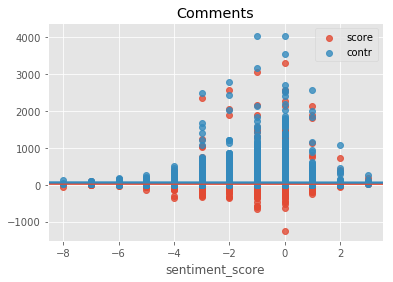

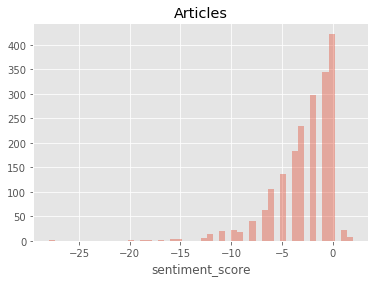

In [6]:
sns.regplot(x='sentiment_score', y='score', data=df_com, label='score')
ax = sns.regplot(x='sentiment_score', y='contr', data=df_com, label='contr')
ax.legend()
plt.ylabel('')
plt.title('Comments')
plt.show()


ax = sns.distplot(df_art['sentiment_score'], kde=False)
plt.title('Articles')
plt.show()

## Topic modeling
Read: http://tidytextmining.com/topicmodeling.html

Use LDA: Each document a mixture of topics and each topic a mixture of words. Built in package?

It's possible to declare what a "document" is. Also look at how each document is classified (per topic). 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

# Parameter selection is intuitive so far
n_samples = 30000
n_features = 50
n_components = 10 # Topics
n_top_words = 30
VERBOSE = True

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "#%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

data_samples = df_com['con']
#data_samples = df_art[df_art['text'].notnull()]['text']

# tf-idf features for NMF (non-negative matrix factorization)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# term frequency (tf) for features for LDA
tf_vectorizer = CountVectorizer(max_df=0.1, min_df=2,
                                max_features=n_features,
                                stop_words=stop_words)
tf = tf_vectorizer.fit_transform(data_samples)

# Fit the NMF model
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
"""
if VERBOSE: print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
if VERBOSE: print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..." % (n_samples, n_features))
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=1000, alpha=.1, l1_ratio=.5).fit(tfidf)
if VERBOSE: print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(nmf, tfidf_feature_names, n_top_words)
"""
if VERBOSE: print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..." % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

if VERBOSE: print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(lda, tf_feature_names, n_top_words)
print('Finished.')

Fitting LDA models with tf features, n_samples=30000 and n_features=50...

Topics in LDA model:
#0: kein machen andere jahren alles will etwas mal also gibt einfach damit viele jetzt wer wäre schweiz tun soll geht keine weil bin heute leben geld nie ob wurde müssen 

#1: keine bin schweiz jetzt also schweizer will anderen gut geht leben machen würde viel weil alles nie gibt einfach wohl viele damit mal warum wurde wäre leute jahren sicher ob 

#2: geht gut geld wurde heute warum viel einfach wäre keine sollte kein mal sicher leute soll jeder viele also alles weil nie jetzt damit leben gibt will tun jahren würde 

#3: immer will dies besser bin einfach müssen wurde mal viel geht gibt nie leben etwas weil leute alles gut kommt keine also anderen damit tun heute soll viele jetzt jeder 

#4: mal wäre viele damit tun einfach viel bin kommt anderen jetzt gut leute soll also alles ob keine leben weil gibt nie schweiz heute wurde warum schweizer würde wirklich immer 

#5: menschen sollte jeder

In [9]:
# For each category of 20M see how the topics are "arranged"
# For classes (score </>= threshold) how often each topic occurs in each comment
threshold = 1
topic_cols = list(map(lambda x: 'topic_' + str(x), range(0, n_components)))

len_high = len(df_com[df_com['score'] >= threshold])
len_low = len(df_com) - len_high
print("Num of comments\thigh: {}\tlow: {}".format(len_high, len_low))

# Probability for each document to belong to a topic
def get_probs_for_topics(text, tf_vectorizer, lda):
    lf = lda.transform(tf_vectorizer.transform([text])).ravel()
    return pd.Series(lf)

t = df_com.apply(lambda x: get_probs_for_topics(x['con'], tf_vectorizer, lda), axis=1)
t.columns = topic_cols
df_com = df_com.join(t, lsuffix='_left')

# Compute sums of topics per class
s = df_com[df_com['score'] >= threshold][topic_cols].sum(axis=0) / len_high
sums = pd.DataFrame(columns=['class', 'prob'])
sums['prob'] = s
sums['class'] = 'high'

s = df_com[df_com['score'] < threshold][topic_cols].sum(axis=0) / len_low
sums2 = pd.DataFrame(columns=['class', 'prob'])
sums2['prob'] = s
sums2['class'] = 'low'
sums = sums.append(sums2)

#print(df_com.head(3))
print(sums)

Num of comments	high: 22492	low: 7508
        class  prob
topic_0  high 0.088
topic_1  high 0.119
topic_2  high 0.106
topic_3  high 0.090
topic_4  high 0.109
topic_5  high 0.090
topic_6  high 0.122
topic_7  high 0.091
topic_8  high 0.088
topic_9  high 0.096
topic_0   low 0.087
topic_1   low 0.125
topic_2   low 0.102
topic_3   low 0.089
topic_4   low 0.112
topic_5   low 0.090
topic_6   low 0.121
topic_7   low 0.089
topic_8   low 0.088
topic_9   low 0.097


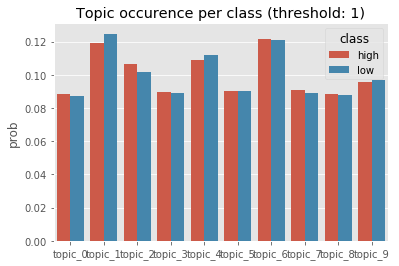

In [10]:
#print(sums_high.index)
#print(sums_high[0])
ax = sns.barplot(x=sums.index, y=sums['prob'], hue=sums['class'])
plt.title('Topic occurence per class (threshold: {})'.format(threshold))
plt.show()

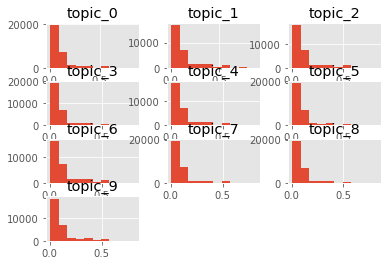

In [11]:
# For each topic, how is the distribution of comments
# = distribution in the columns topic_0, topic_1, ...
column = []
for i in range(0, n_components):
    column.append('topic_' + str(i))
a = df_com.hist(column=column)

In [ ]:
# Where does the comments lie compared to the topics on a cartesian plane
import random
from math import floor
import networkx as nx

G = nx.Graph()

# Show for this topics
components_list = [0, 1, 2]

for t in components_list:
    G.add_node(t, color='red')
    
# Only for a subset because of computation time
for i, row in df_com[:1000].iterrows():
    add_weighted = []
    G.add_node(i, color='black')
    for t in components_list:
        w = row['topic_' + str(t)]
        add_weighted.append((i, t, w))
        
    G.add_weighted_edges_from(add_weighted)
    
nodes = G.nodes()
colors = [G.node[n]['color'] for n in nodes]
size_by_color = {'red': 300, 'black': 1}
sizes = [size_by_color[G.node[n]['color']] for n in nodes]
    
fixedpos = {0:(0,0), 1:(1,1), 2: (0, 1)}
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, fixed = fixedpos.keys(), pos = fixedpos)
nx.draw_networkx(G, pos=pos, with_labels=False, width=0, node_color=colors, node_size=sizes)

plt.show()